In [1]:
import config

import os
from Bio import SeqIO
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import re

os.chdir(config.DIR_ROOT)

In [2]:
from n02_scripts.n04_create_dataset import create_dataset
from n02_scripts.n05_kmer_statistics import kmer_distribution
from n02_scripts.n07_create_kmer_embeddings import create_kmer_embeddings

# Описание данных

In [3]:
insect_map = pd.read_csv(config.FILE_INSECT_MAP)
insect_map.head()

,name,insect,partition,type,length
0,SVgr_1_id_00001|220,anopheles_albimanus,NaN,NaN,220
1,SVgr_1_id_00003|86,anopheles_albimanus,NaN,NaN,86
2,SVgr_1_id_00005|70,anopheles_albimanus,NaN,NaN,70
3,SVgr_1_id_00009|222,anopheles_albimanus,NaN,NaN,222
4,SVgr_1_id_00018|676,anopheles_albimanus,NaN,NaN,676


In [4]:
insect_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699517 entries, 0 to 1699516
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   name       object 
 1   insect     object 
 2   partition  float64
 3   type       object 
 4   length     int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 64.8+ MB


## Сколько всего последовательностей

In [5]:
len(insect_map)

1699517

## Сколько последовательностей проаннотировано типом

In [6]:
print('Проаннотировано типом:', len(insect_map) - insect_map['type'].isna().sum())
print('Проаннотировано типом (проценты):', (1 - (insect_map['type'].isna().sum() / len(insect_map))) * 100, '%')


Проаннотировано типом: 33457
Проаннотировано типом (проценты): 1.9686181426840643 %


## Сколько последовательностей полностью проаннотированы типом и partition

In [7]:
count_nones = insect_map[insect_map['type'].isna() | insect_map['partition'].isna()].shape[0]
print('Проаннотировано типом и partition:', len(insect_map) - count_nones)
print('Проаннотировано типом и partition (проценты):', (1 - (count_nones / len(insect_map))) * 100, '%')

Проаннотировано типом и partition: 33457
Проаннотировано типом и partition (проценты): 1.9686181426840643 %


## Сколько последовательностей с уникальным partition

In [8]:
insect_map_clean = insect_map.dropna(subset=['type', 'partition'])
unique_pairs_count = insect_map_clean[['partition', 'insect']].drop_duplicates().shape[0]
print('Число уникальных partition', unique_pairs_count)
print('Число уникальных partition (проценты)', (unique_pairs_count / len(insect_map_clean)) * 100, '%')

Число уникальных partition 3108
Число уникальных partition (проценты) 9.289535822100008 %


## Распределение количества последовательностей с определенным типом

### Уникальные значения

In [9]:
unique_types = insect_map_clean['type'].unique()
print(unique_types)

types_distribution_df = insect_map_clean['type'].value_counts().reset_index()
types_distribution_df.columns = ['type', 'count']

total = len(insect_map_clean)
types_distribution_df['percent'] = (types_distribution_df['count'] / total * 100).round(2)

print(types_distribution_df)

['cacta' 'gypsy' 'line' 'copia' 'hat' 'l1' 'helitron' 'mudr']
       type  count  percent
0      line  15307    45.75
1     gypsy   8466    25.30
2        l1   5869    17.54
3     copia   1547     4.62
4       hat   1028     3.07
5  helitron    733     2.19
6     cacta    284     0.85
7      mudr    223     0.67


In [10]:
naming_dict = {'line': 'line',
 'l1': 'line',
 'gypsy': 'gypsy',
 'copia': 'gypsy',
 'mudr': 'mudr',
 'hat': 'mudr',
 'cacta': 'mudr',
 'helitron': 'helitron'}

In [11]:
insect_map_correct_types = insect_map_clean.copy()
insect_map_correct_types['type'] = insect_map_correct_types['type'].map(naming_dict).fillna(insect_map_correct_types['type'])

In [12]:
types_distribution_df = insect_map_correct_types['type'].value_counts().reset_index()
types_distribution_df.columns = ['type', 'count']

total = len(insect_map_correct_types)
types_distribution_df['percent'] = (types_distribution_df['count'] / total * 100).round(2)

print(types_distribution_df)

       type  count  percent
0      line  21176    63.29
1     gypsy  10013    29.93
2      mudr   1535     4.59
3  helitron    733     2.19


## Распреление типов для последовательностей из одного partition

In [13]:
# partition_id - уникальный индентификатор для каждой пары (partition, insect)
insect_unique_partition_id = (
    insect_map_correct_types[["partition", "insect"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "partition_id"})
)
insect_unique_partition_id.shape

(3108, 3)

In [14]:
insect_map_correct_types = insect_map_correct_types.merge(
    insect_unique_partition_id,
    on=["partition", "insect"],
    how="right"
)

In [15]:
33457 - 49 - 10-9-9-4-3-2-1-1

33369

In [16]:
type_sets = (
    insect_map_correct_types
    .groupby("partition_id")["type"]
    .apply(lambda x: tuple(sorted(set(x))))
)

type_distribution_counts = type_sets.value_counts()

print(type_distribution_counts)

type
(line,)                    1657
(gypsy,)                   1095
(mudr,)                     224
(gypsy, line)                49
(helitron,)                  44
(gypsy, mudr)                10
(gypsy, line, mudr)           9
(line, mudr)                  9
(gypsy, helitron)             4
(gypsy, helitron, line)       3
(helitron, line)              2
(helitron, mudr)              1
(gypsy, helitron, mudr)       1
Name: count, dtype: int64


## С "развернутым" набором типов

In [17]:
insect_multi_type_unique_partition_id = (
    insect_map_clean[["partition", "insect"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "partition_id"})
)
insect_multi_type_unique_partition_id.shape

(3108, 3)

In [18]:
insect_map_clean = insect_map_clean.merge(
    insect_multi_type_unique_partition_id,
    on=["partition", "insect"],
    how="right"
)

In [19]:
type_sets = (
    insect_map_clean
    .groupby("partition_id")["type"]
    .apply(lambda x: tuple(sorted(set(x))))
)

type_distribution_counts = type_sets.value_counts()

print(type_distribution_counts)

type
(line,)                                 1158
(gypsy,)                                 942
(l1,)                                    338
(l1, line)                               161
(copia,)                                 150
(hat,)                                   143
(cacta,)                                  47
(helitron,)                               44
(mudr,)                                   32
(gypsy, line)                             28
(gypsy, l1, line)                         13
(gypsy, l1)                                5
(gypsy, helitron)                          4
(hat, line)                                3
(cacta, gypsy)                             3
(gypsy, helitron, line)                    3
(copia, gypsy)                             3
(gypsy, hat)                               2
(hat, l1)                                  2
(helitron, line)                           2
(gypsy, mudr)                              2
(cacta, mudr)                              2
(copi

### Рассматриваем "сжатые" последовательности, выкидываем "смешенные по типам" partitions

In [20]:
# Оставляем только те строки, где у partition_id ровно один уникальный type
insect_map_unique_type_partition = insect_map_correct_types[
    insect_map_correct_types.groupby("partition_id")["type"]
    .transform("nunique") == 1
]
insect_map_unique_type_partition

,name,insect,partition,type,length,partition_id
0,SVgr_5_id_2735|1344,anopheles_albimanus,6.0,mudr,1344,0
1,SVgr_5_id_2737|1008,anopheles_albimanus,6.0,mudr,1008,0
2,SVgr_1_id_000248|5908,anopheles_arabiensis,6.0,gypsy,5908,1
3,SVgr_1_id_172747|5907,anopheles_arabiensis,6.0,gypsy,5907,1
4,SVgr_1_id_221186|5910,anopheles_arabiensis,6.0,gypsy,5910,1
...,...,...,...,...,...,...
33452,SVgr_7_id_5242|15651,insect_venturia_canescens,52.0,mudr,15651,3105
33453,SVgr_4_id_7720|6451,insect_venturia_canescens,36.0,mudr,6451,3106
33454,SVgr_5_id_3028|21289,insect_venturia_canescens,30.0,mudr,21289,3107
33455,SVgr_5_id_3045|21349,insect_venturia_canescens,30.0,mudr,21349,3107


# Создание датасетов для разных значений k

In [ ]:
k_list = [4, 5, 6, 7]
create_kmer_embeddings(insect_map_unique_type_partition, k_list, mode=0, seed=1)

## Создание датасета из большого набора данных

In [ ]:
FASTA_PATH = config.FILE_INSECT_MANY_FASTA
OUTPUT_PATH = config.DIR_INCEST_MANY


def read_fasta(path: str):
    name = None
    chunks = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if name is not None:
                    yield name, "".join(chunks)
                name = line[1:].strip()
                chunks = []
            else:
                chunks.append(line)
        if name is not None:
            yield name, "".join(chunks)

fasta_records = list(read_fasta(FASTA_PATH))
for k in [4, 5, 6, 7]:
    records = []
    for name, seq in tqdm(fasta_records, desc=f"k={k}"):
        _, emb = kmer_distribution(seq, k)
        record = {"name": name}
        record.update({f"emb_{i}": val for i, val in enumerate(emb)})
        records.append(record)

    df = pd.DataFrame(records)
    out_path = os.path.join(OUTPUT_PATH, f"{k}.csv")
    df.to_csv(out_path, index=False)

k=4:   6%|▌         | 6360/102258 [06:43<1:46:47, 14.97it/s]

# Создание датасета

In [22]:
dataset_df = create_dataset(insect_map_unique_type_partition, mode=0, seed=1)

In [23]:
dataset_df

,name,insect,partition,type,length,partition_id
0,SVgr_5_id_2735|1344,anopheles_albimanus,6.0,mudr,1344,0
1,SVgr_2_id_273948|5911,anopheles_arabiensis,6.0,gypsy,5911,1
2,SVgr_1_id_147691|4387,anopheles_arabiensis,7.0,line,4387,2
3,SVgr_2_id_168601|6298,anopheles_arabiensis,9.0,line,6298,3
4,SVgr_2_id_188427|4400,anopheles_arabiensis,14.0,gypsy,4400,4
...,...,...,...,...,...,...
3015,SVgr_2_id_6058|5193,insect_venturia_canescens,49.0,line,5193,3103
3016,SVgr_5_id_3132|13347,insect_venturia_canescens,50.0,gypsy,13347,3104
3017,SVgr_4_id_0142|15093,insect_venturia_canescens,52.0,mudr,15093,3105
3018,SVgr_4_id_7720|6451,insect_venturia_canescens,36.0,mudr,6451,3106


In [ ]:
k = 7
dataset_embeddings = pd.DataFrame(columns=["name", "type", "embedding"])

for index, row in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
    insect_name = row['insect']
    sequence_path = os.path.join(config.DIR_GRAPH_PARTITION, f'{insect_name}_seq.fasta')
    rec_sequence = next((r for r in SeqIO.parse(sequence_path, "fasta") if r.id == row['name']), None)
    sequence = str(rec_sequence.seq)
    _, kmer_embedding = kmer_distribution(sequence, k)
    new_row = pd.DataFrame([[row['name'], row['type'], kmer_embedding]],
                       columns=["name", "type", "embedding"])
    dataset_embeddings = pd.concat([dataset_embeddings, new_row], ignore_index=True)

In [25]:
dataset_embeddings.shape

(36, 3)

In [26]:
dataset_embeddings.head

<bound method NDFrame.head of                       name   type  \
0      SVgr_5_id_2735|1344   mudr   
1    SVgr_2_id_273948|5911  gypsy   
2    SVgr_1_id_147691|4387   line   
3    SVgr_2_id_168601|6298   line   
4    SVgr_2_id_188427|4400  gypsy   
5    SVgr_2_id_153539|4827  gypsy   
6    SVgr_1_id_010358|4290   line   
7    SVgr_1_id_205642|7165  gypsy   
8    SVgr_1_id_018948|5986  gypsy   
9    SVgr_2_id_148368|1384   line   
10   SVgr_1_id_249250|4542  gypsy   
11  SVgr_1_id_167364|13523   mudr   
12   SVgr_1_id_153209|4435  gypsy   
13   SVgr_1_id_198111|3325   line   
14   SVgr_2_id_236763|1586   line   
15   SVgr_2_id_117425|4001   line   
16   SVgr_1_id_111070|3174   line   
17   SVgr_1_id_273527|7356  gypsy   
18    SVgr_3_id_44488|7576  gypsy   
19   SVgr_1_id_031202|4260  gypsy   
20   SVgr_1_id_152320|6234   line   
21    SVgr_3_id_42051|3189   line   
22   SVgr_1_id_066748|4214   line   
23   SVgr_1_id_169847|1674   line   
24   SVgr_1_id_148000|3074   line   
25   SVg

# Статистика для большого набора данных

## t-SNE Визуализация

In [3]:
df_info = pd.read_csv('/Users/nad/hse/semester07/mobiraph/n01_data/n06_insects_many/repbase_orf_type.txt', sep="\t")

In [4]:
ks = [4, 5, 6, 7]

(102258, 256)


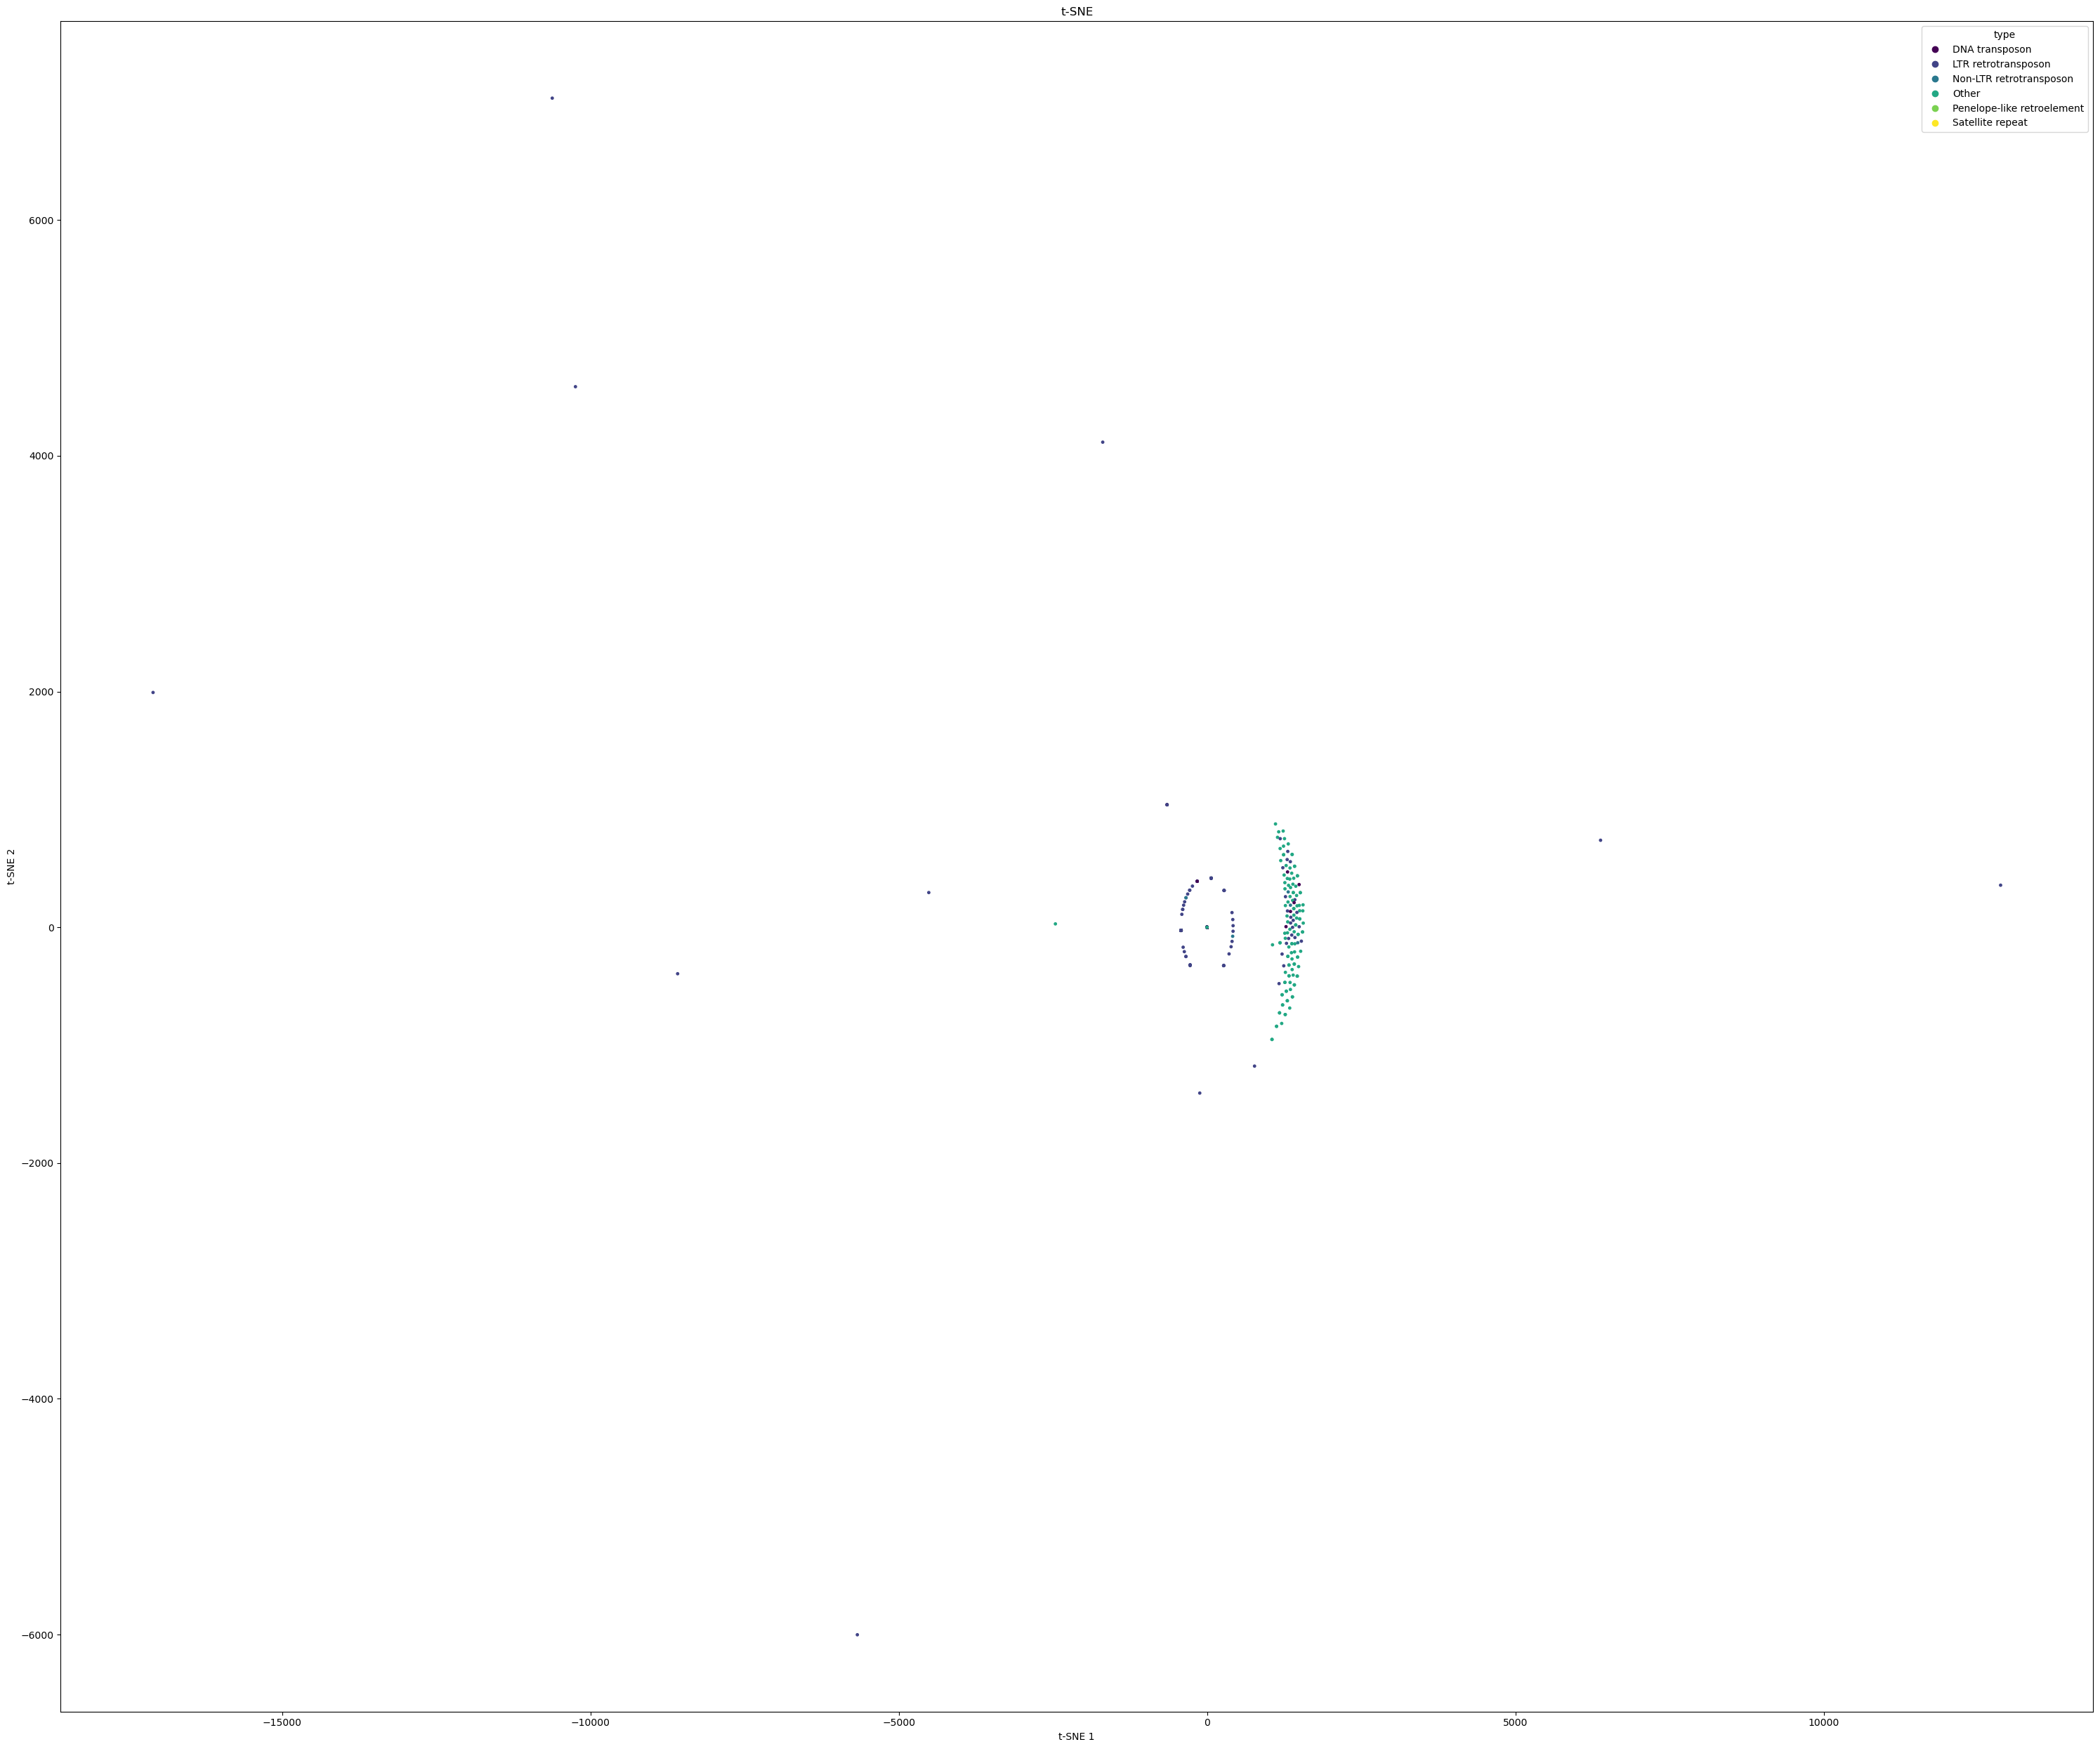

(102258, 668)


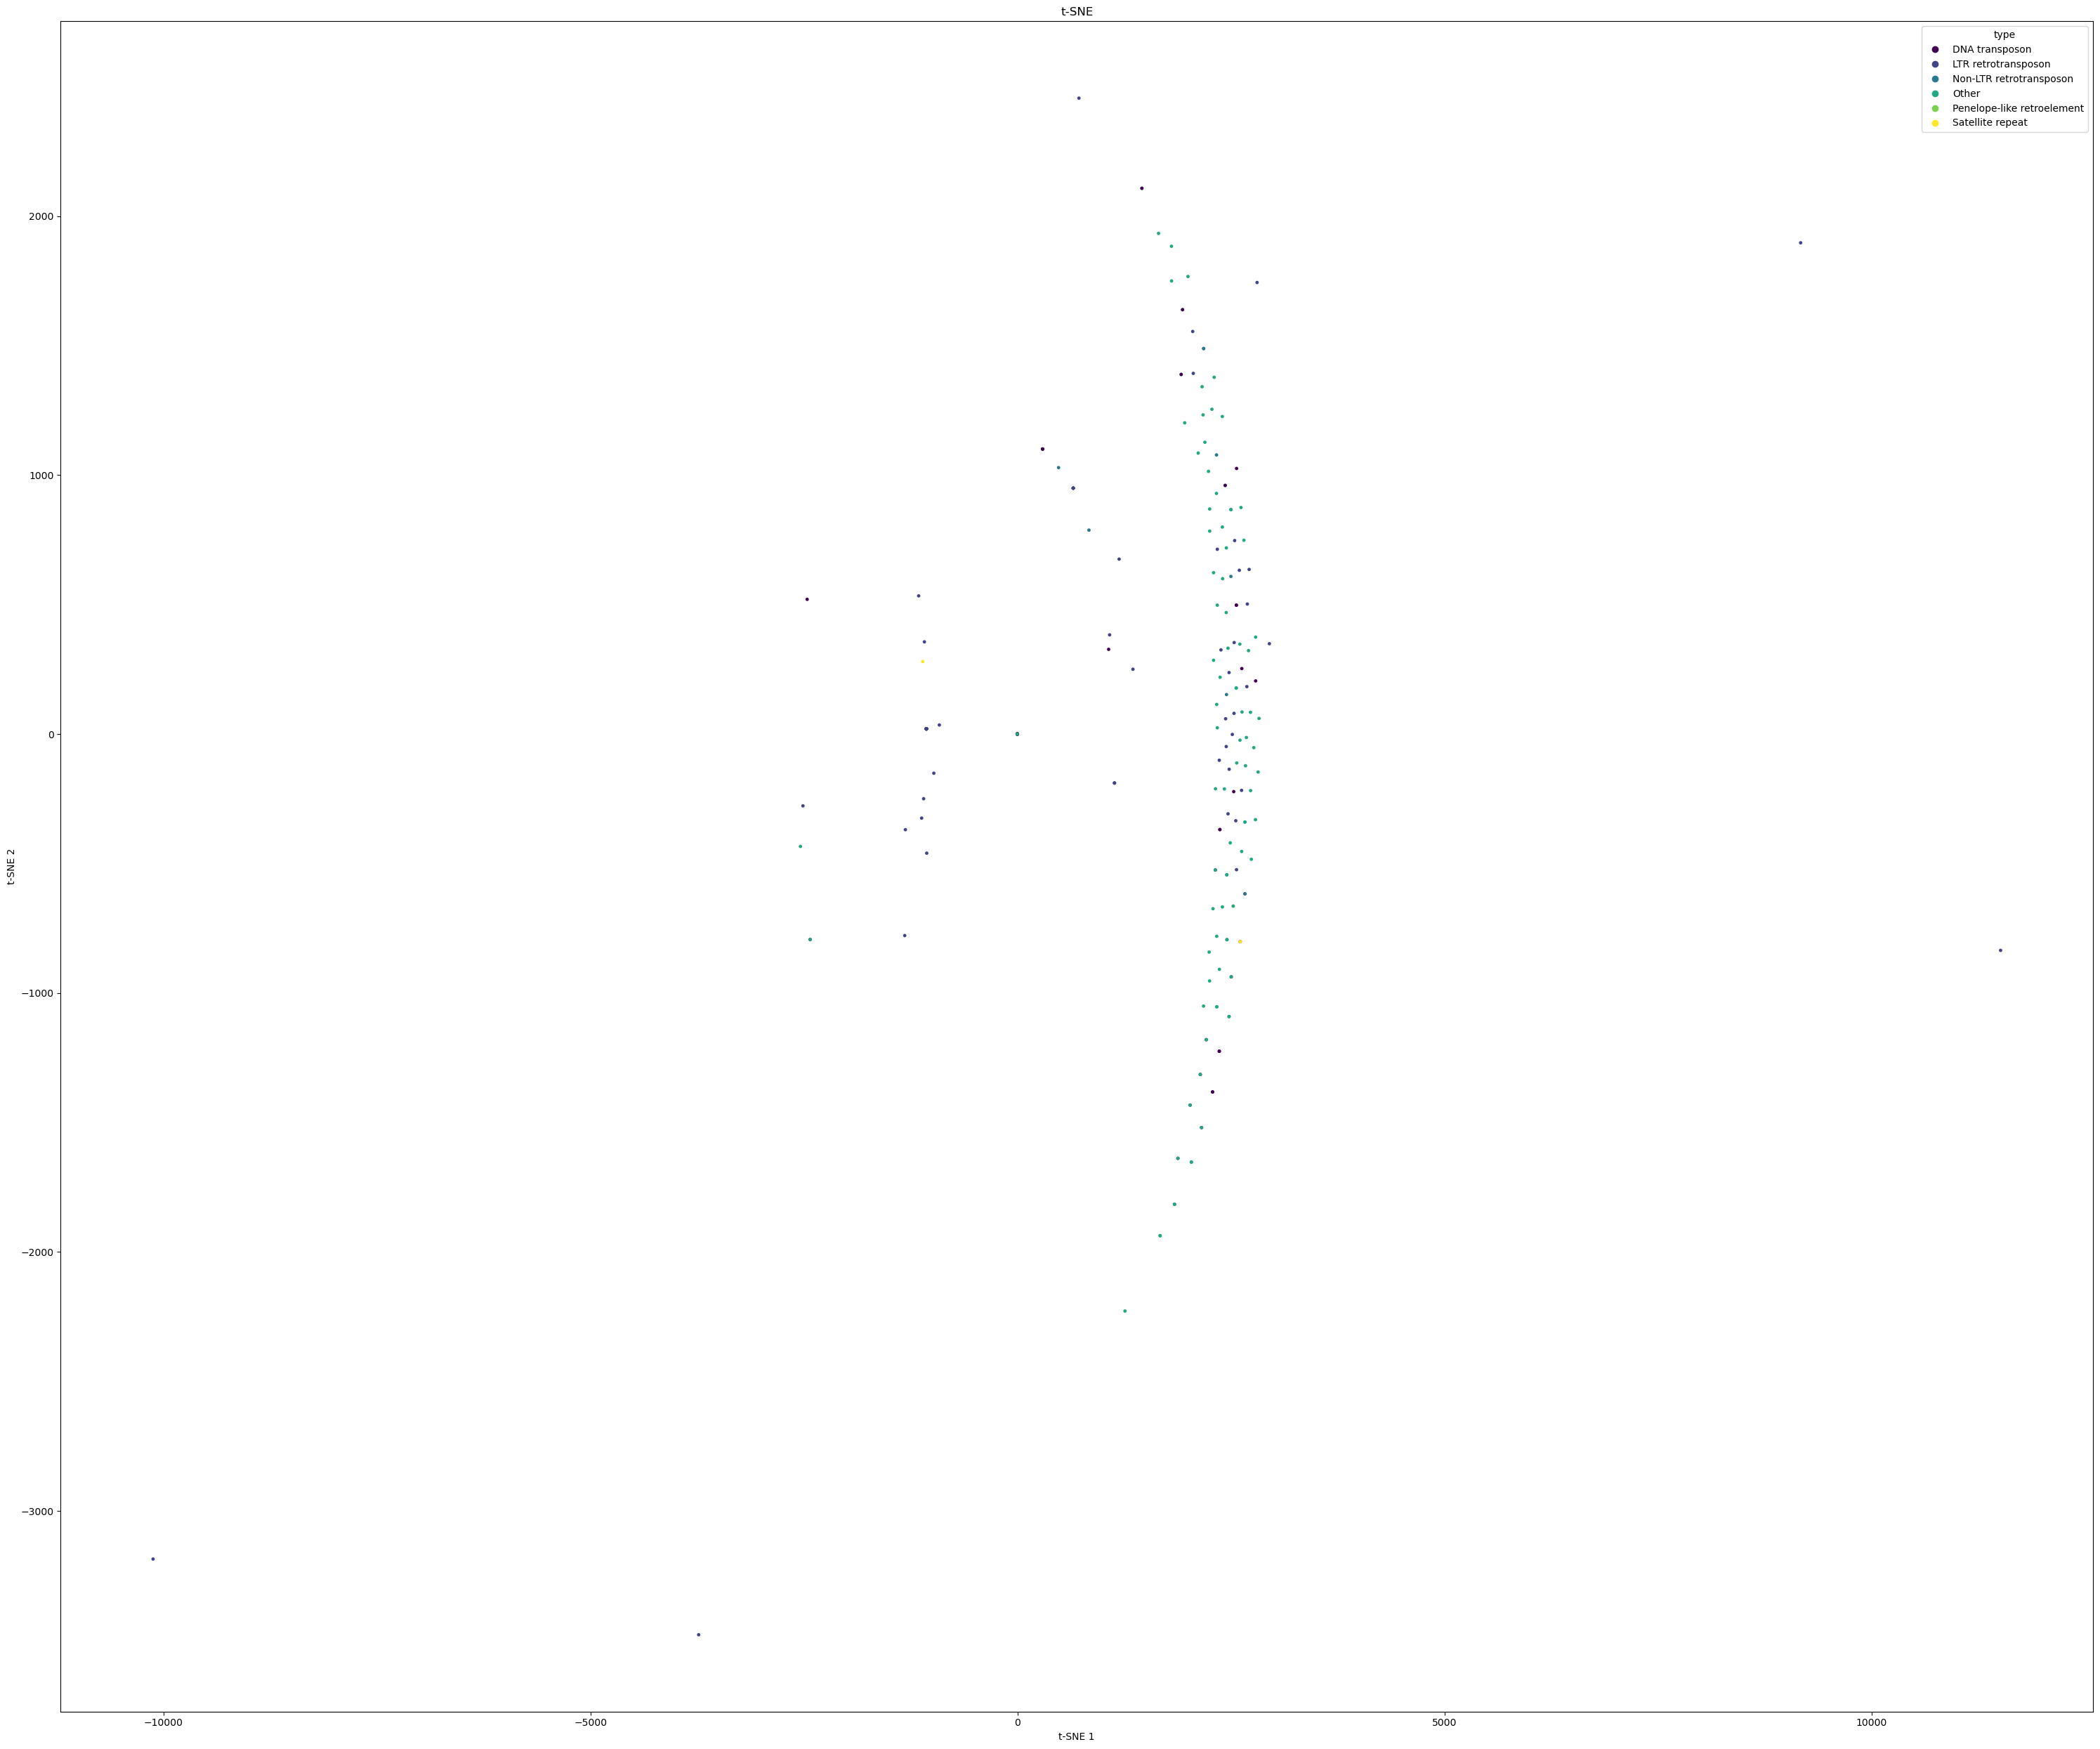

(102258, 862)


KeyboardInterrupt: 

In [5]:
for k in ks:
    path_to_dataset = os.path.join(config.DIR_INCEST_MANY, f'{k}_trimmed.csv')
    dataset_load = pd.read_csv(path_to_dataset)
    print(dataset_load.shape)
    emb_cols = [c for c in dataset_load.columns if re.fullmatch(r"emb_\d+", c)]
    mask_X = dataset_load[emb_cols].notna().all(axis=1)
    mask_y = df_info["MainType"].notna()
    common_idx = dataset_load.index[mask_X].intersection(df_info.index[mask_y])
    X = dataset_load.loc[common_idx, emb_cols].to_numpy(dtype=float)
    le = LabelEncoder()
    y = le.fit_transform(df_info.loc[common_idx, "MainType"])
    Xs = StandardScaler().fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30, init="pca", initia)
    X_red = tsne.fit_transform(Xs)
    plt.figure(figsize=(30, 25))
    sc = plt.scatter(
        X_red[:, 0],
        X_red[:, 1],
        c=y,
        s=6,
        cmap="viridis"
    )

    handles, _ = sc.legend_elements()
    plt.legend(handles, le.classes_, title="type", loc="best")

    plt.title("t-SNE")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()

In [33]:
print("len(dataset_load):", len(dataset_load))
print("mask_X sum:", mask_X.sum())
print("len(df_info):", len(df_info), "mask_y sum:", mask_y.sum())
print("dup idx in dataset_load:", dataset_load.index.has_duplicates)
print("dup idx in df_info:", df_info.index.has_duplicates)
print("len(common_idx):", len(common_idx))


len(dataset_load): 102258
mask_X sum: 102258
len(df_info): 100498 mask_y sum: 100498
dup idx in dataset_load: False
dup idx in df_info: False
len(common_idx): 100498


X before PCA: 100498
y before PCA: 100498
after filter: 100351


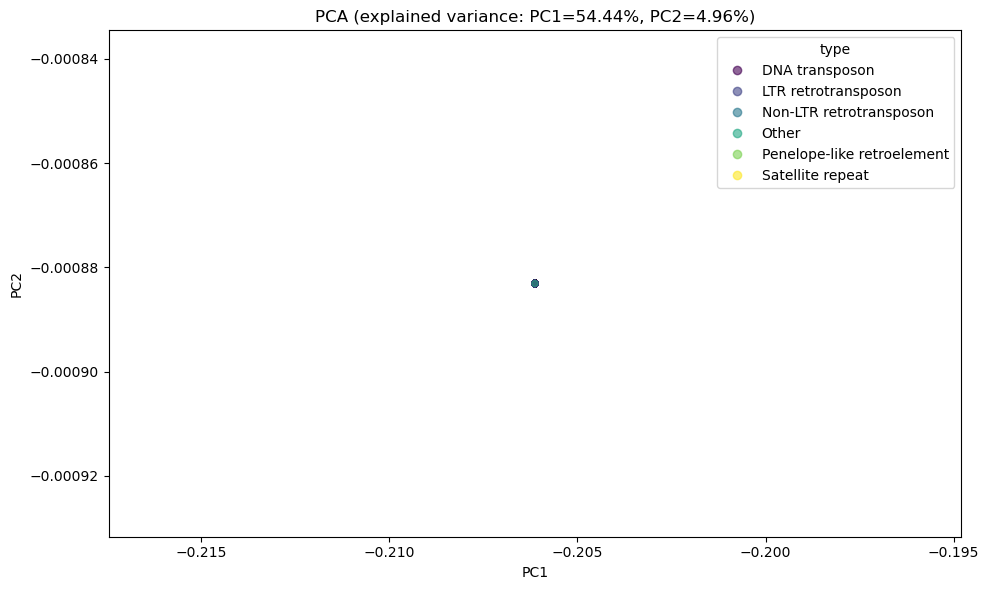

X before PCA: 100498
y before PCA: 100498
after filter: 100351


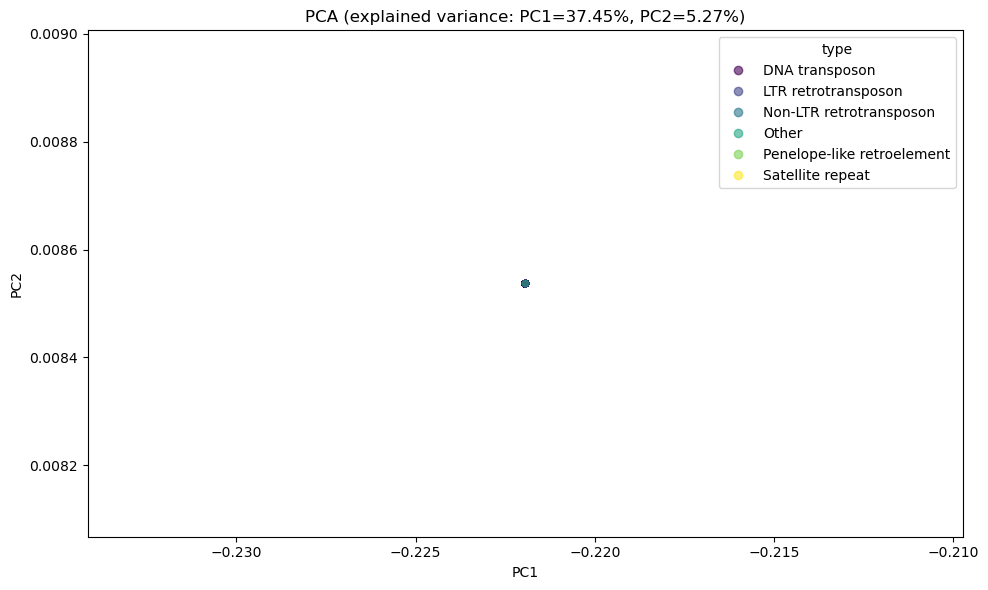

X before PCA: 100498
y before PCA: 100498
after filter: 100353


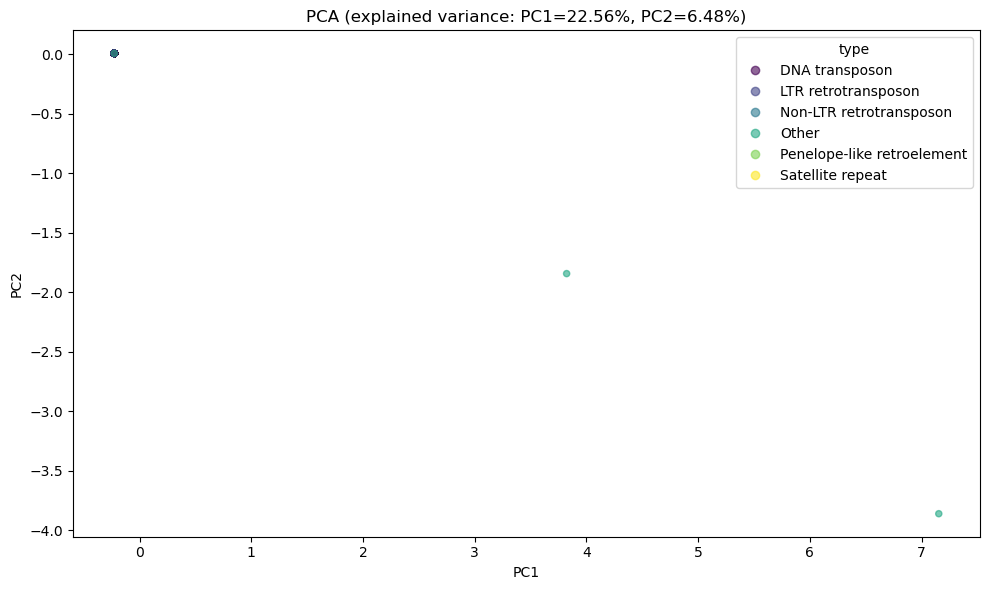

X before PCA: 100498
y before PCA: 100498
after filter: 100354


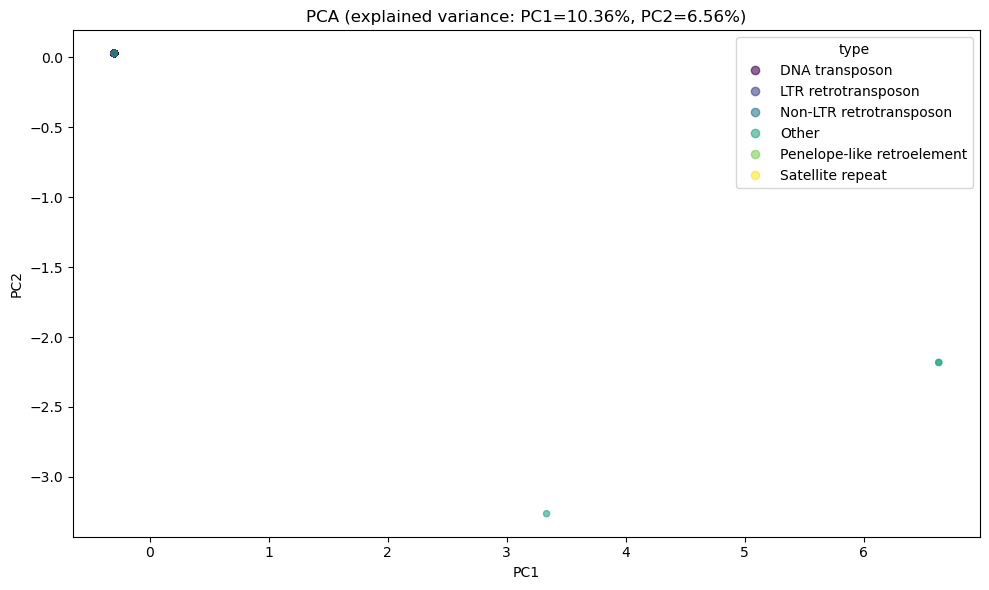

In [35]:
for k in ks:
    path_to_dataset = os.path.join(config.DIR_INCEST_MANY, f'{k}_trimmed.csv')
    dataset_load = pd.read_csv(path_to_dataset)

    emb_cols = [c for c in dataset_load.columns if re.fullmatch(r"emb_\d+", c)]
    mask_X = dataset_load[emb_cols].notna().all(axis=1)
    mask_y = df_info["MainType"].notna()
    common_idx = dataset_load.index[mask_X].intersection(df_info.index[mask_y])

    X = dataset_load.loc[common_idx, emb_cols].to_numpy(dtype=float)
    print("X before PCA:", len(X))

    le = LabelEncoder()
    y = le.fit_transform(df_info.loc[common_idx, "MainType"])
    print("y before PCA:", len(y))

    # Стандартизация
    Xs = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2, svd_solver="auto", random_state=0)
    X_red = pca.fit_transform(Xs)
    evr = pca.explained_variance_ratio_

    # --- Фильтр по PC1 ---
    mask_vis = X_red[:, 0] <= 10
    X_red = X_red[mask_vis]
    y = y[mask_vis]
    print("after filter:", len(X_red))

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(
        X_red[:, 0],
        X_red[:, 1],
        c=y,
        s=20,
        cmap="viridis",
        alpha=0.6
    )

    handles, _ = sc.legend_elements()
    plt.legend(handles, le.classes_, title="type", loc="best")

    plt.title(f"PCA (explained variance: PC1={evr[0]:.2%}, PC2={evr[1]:.2%})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()


# Статистика для маленького набора данных

## PCA Визуализация

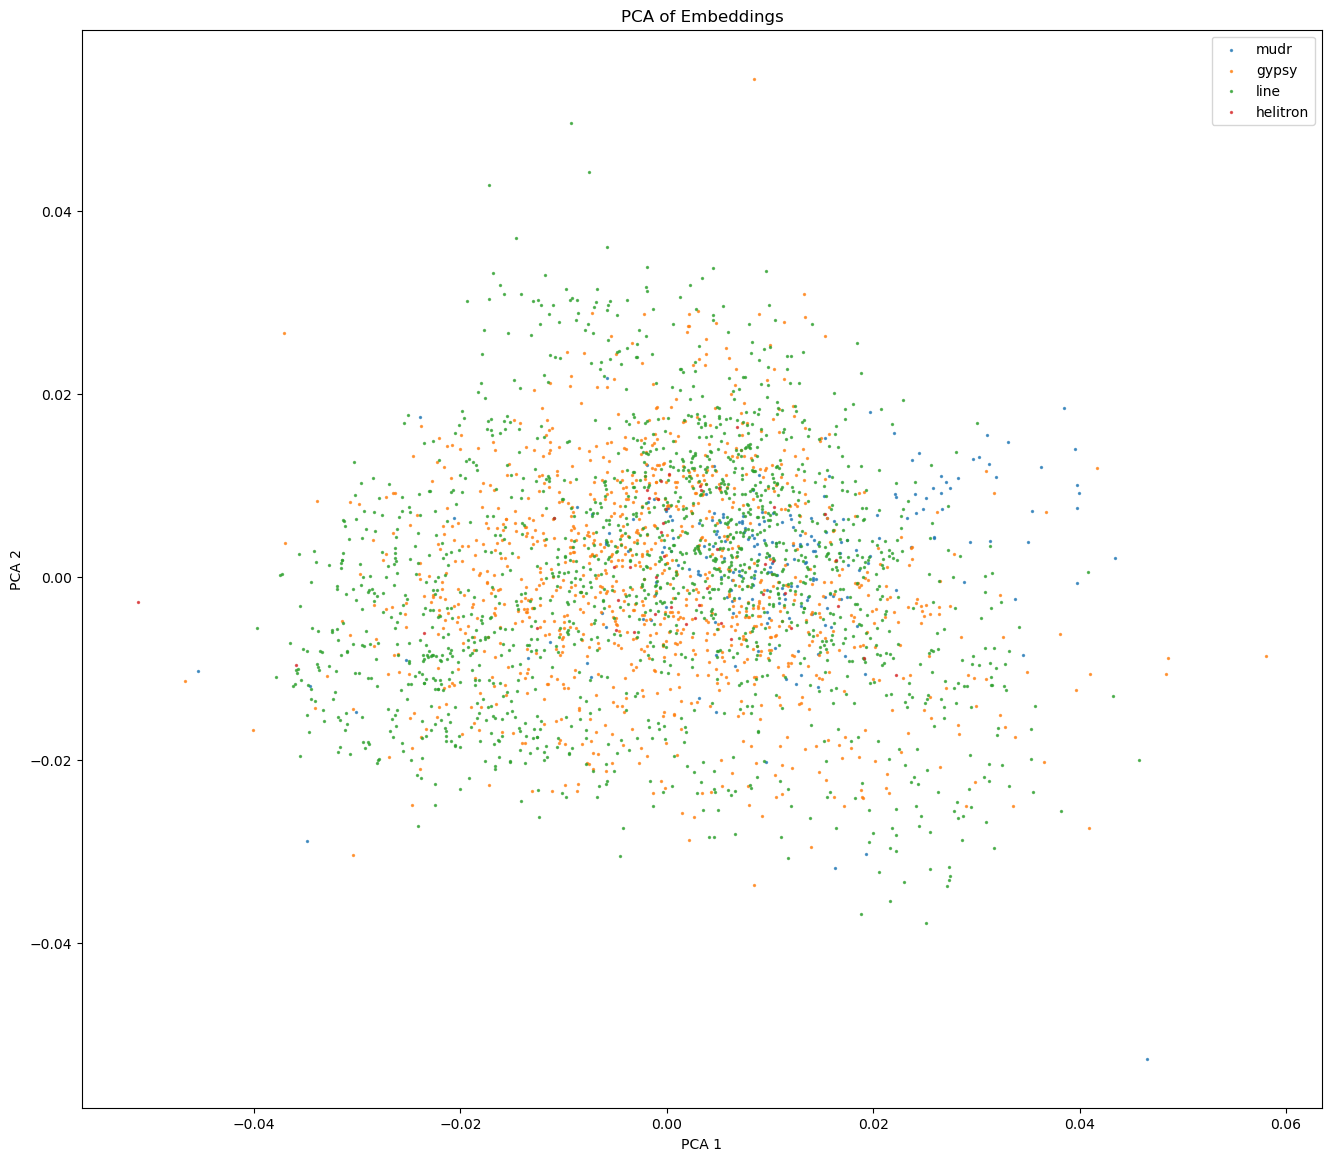

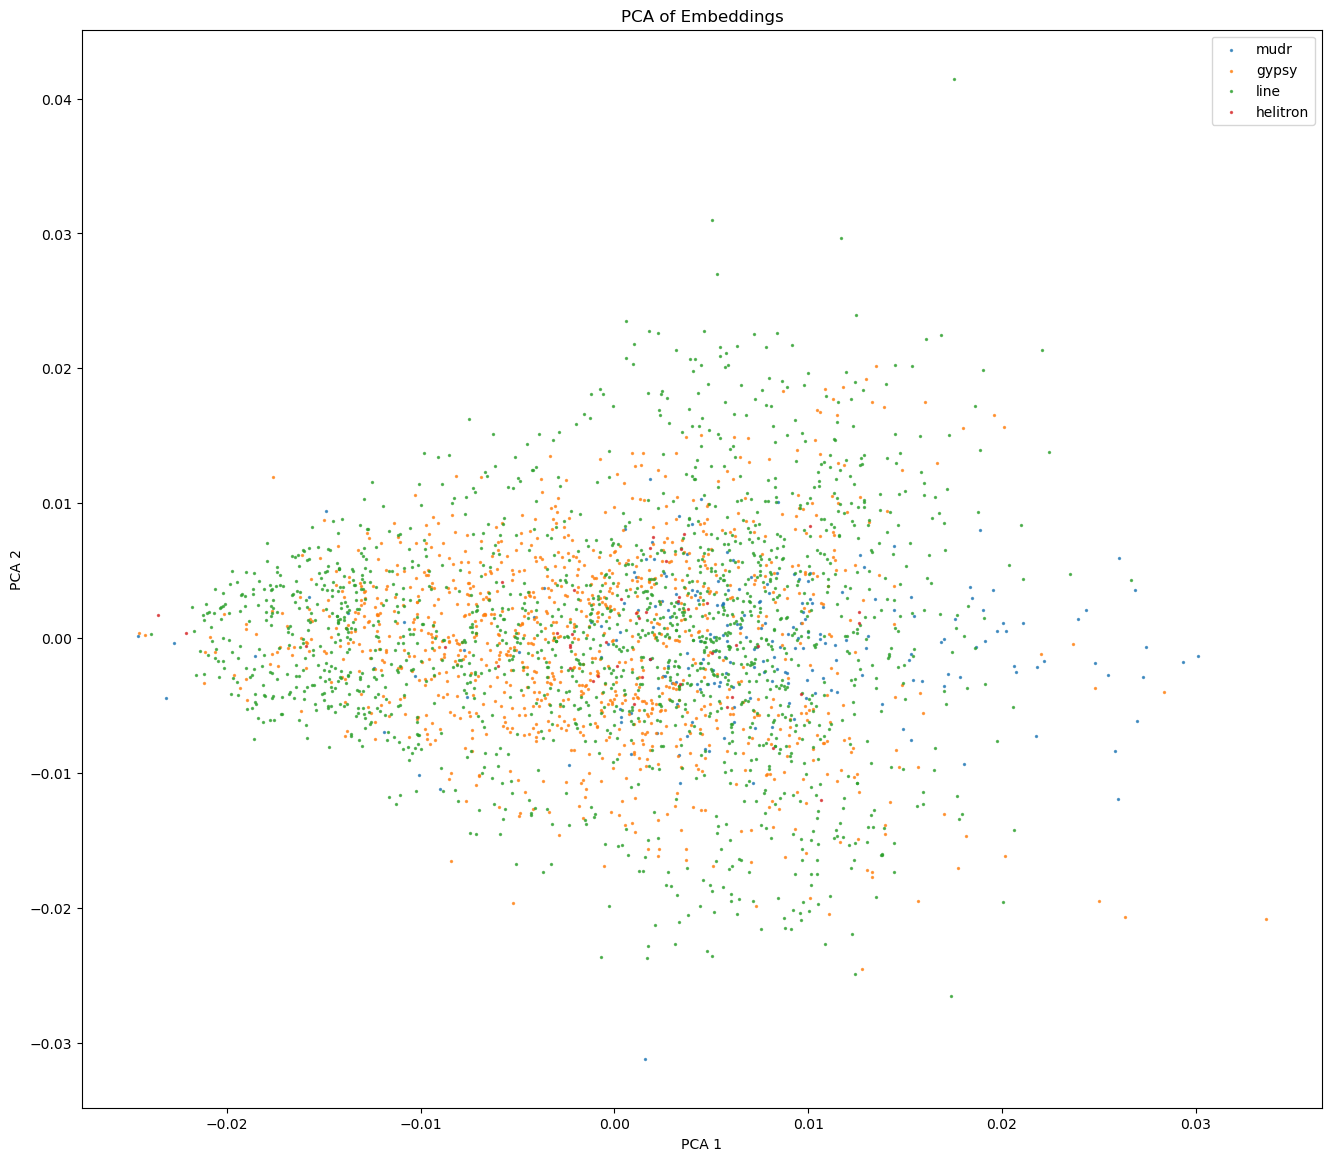

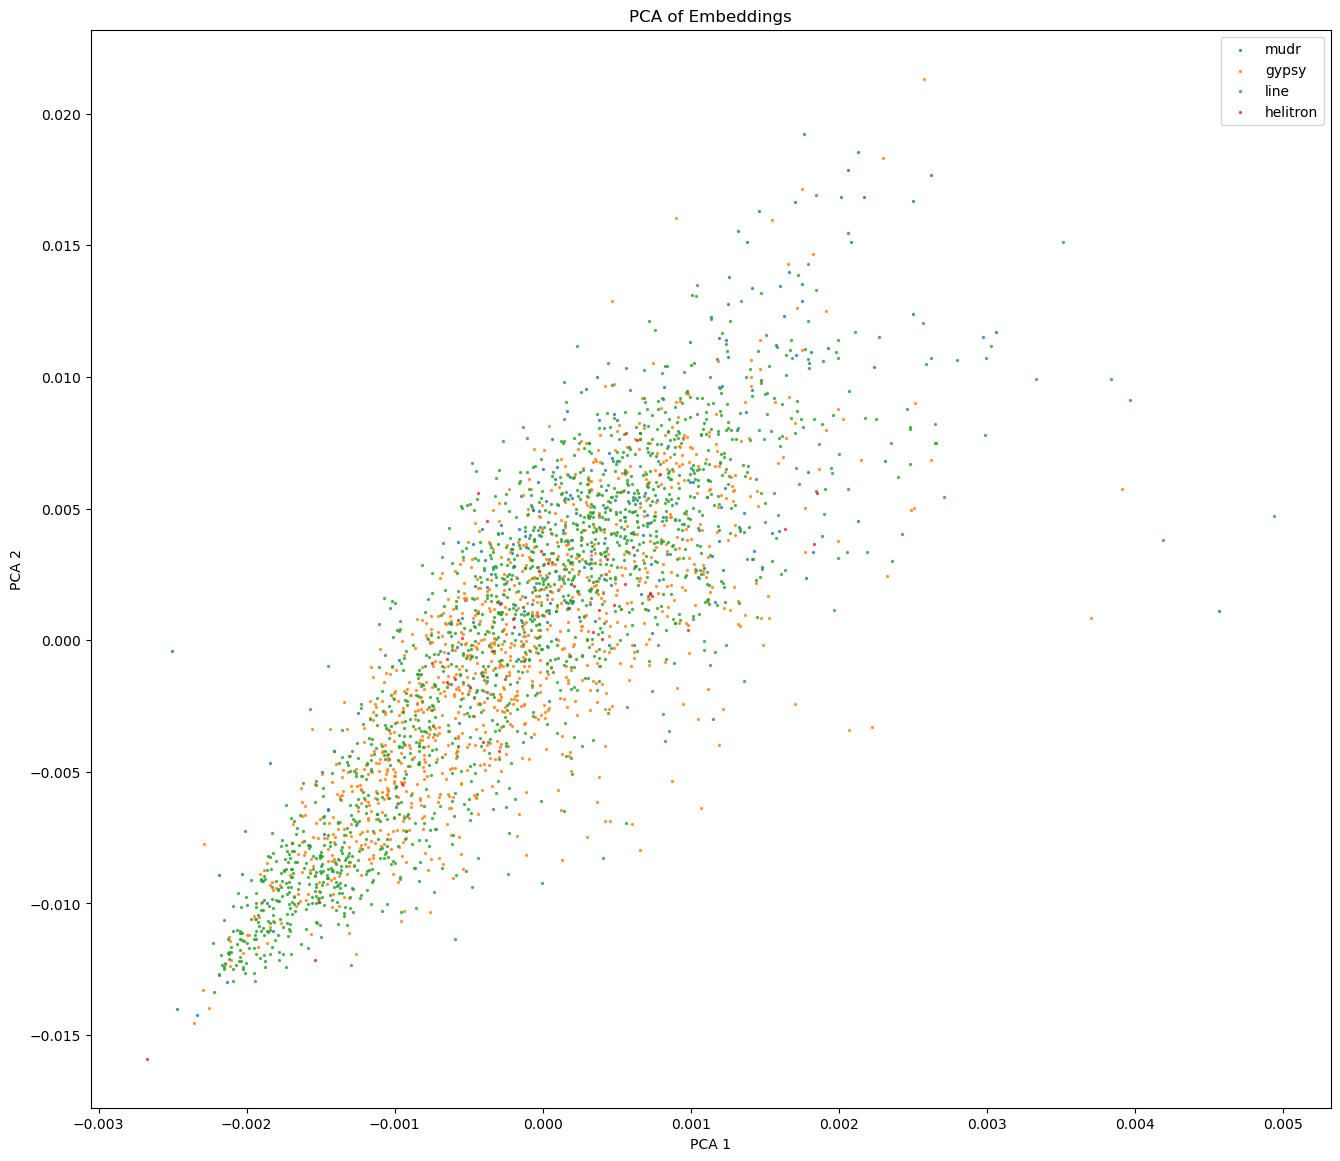

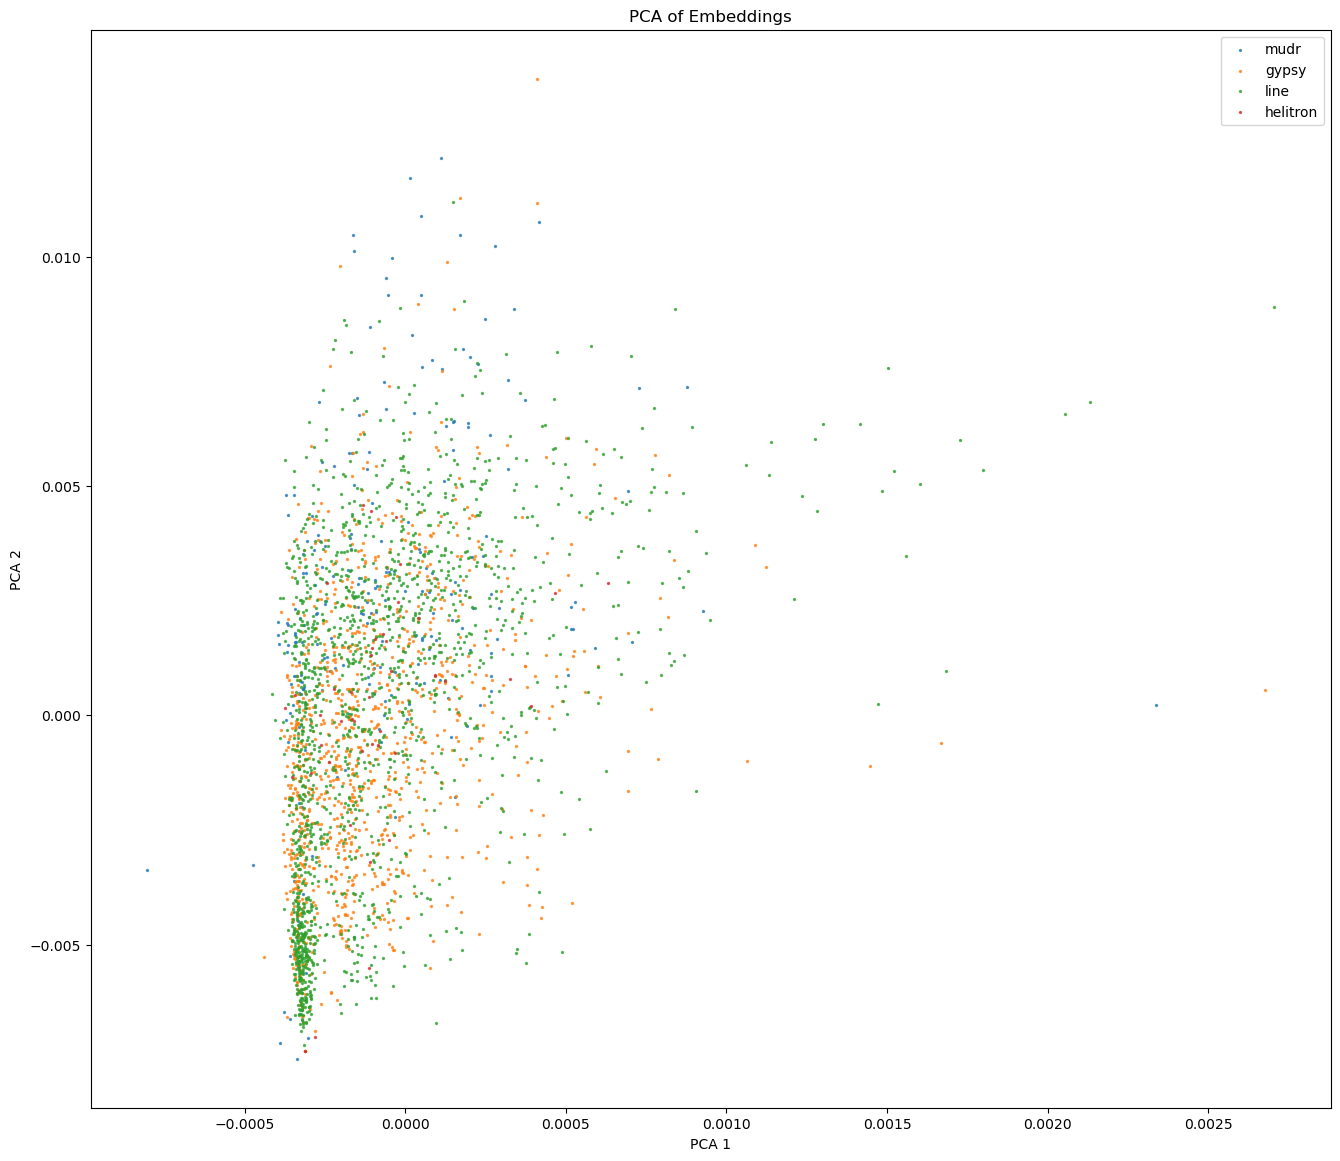

In [7]:
mode = 0
seed = 1
for k in ks:
    path_to_dataset = os.path.join(config.DIR_KMER_DATASETS, f'{k}_{mode}_{seed}_trimmed.csv')
    dataset_load = pd.read_csv(path_to_dataset)
    emb_cols = [c for c in dataset_load.columns if re.fullmatch(r"emb_\d+", c)]
    mask_X = dataset_load[emb_cols].notna().all(axis=1)
    mask_y = df_info["MainType"].notna()
    common_idx = dataset_load.index[mask_X].intersection(df_info.index[mask_y])
    X = dataset_load.loc[common_idx, emb_cols].to_numpy(dtype=float)

    # PCA до 2 компонент
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Добавим координаты в DataFrame
    dataset_load["pca1"] = X_pca[:, 0]
    dataset_load["pca2"] = X_pca[:, 1]

    plt.figure(figsize=(16, 14))


    for t in dataset_load["type"].unique():
        subset = dataset_load[dataset_load["type"] == t]
        subset = subset[subset["pca1"] < 0.2]
        plt.scatter(subset["pca1"], subset["pca2"], label=t, alpha=0.7, s=2)

    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("PCA of Embeddings")
    plt.legend()
    plt.show()